In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import os
from scipy import signal, optimize

In [44]:
def load_dataset():
    df_list = []
    
    for directory in ['matrix-mul', 'cublas', 'cuda-tensor']:
        files = os.listdir(directory)
        # Get efimon files
        for i in files:
            if 'efimon' in i:
                df = pd.read_csv(os.path.join(directory, i)).iloc[2:30]
                name = i.split('-')[1].split('.')[0]
                df["sleep_us"] = int(name)
                df["benchmark"] = directory
                df_list.append(df)
    # Concat everything
    df = pd.concat([i for i in df_list if i is not None])
    return df

In [160]:
def load_histograms():
    df = pd.DataFrame()
    files = ['ptx/cublas.csv', 'ptx/cudaTensorCoreGemm.csv', 'ptx/matrixMul.csv']
    for i in files:
        dft = pd.read_csv(i).transpose()
        name = i.split('/')[1].split('.')[0]
        df[name] = dft
    # Concat everything
    return df

In [161]:
df = load_dataset()
dfh = load_histograms()

# Raw Data

In [7]:
df.head()

,OverallUsage(perc),OverallMemory(perc),OverallPower(W),ClockSM(MHz),ClockMEM(MHz),sleep_us,benchmark
2,64,23,158.824,1380,877,20000,matrix-mul
3,64,23,158.496,1380,877,20000,matrix-mul
4,64,23,158.448,1380,877,20000,matrix-mul
5,64,23,157.919,1380,877,20000,matrix-mul
6,64,23,157.728,1380,877,20000,matrix-mul


In [162]:
dfh

,cublas,cudaTensorCoreGemm,matrixMul
vector_arithmetic,0.000000,0.403460,0.000000
vector_memory,0.114754,0.520088,0.000000
branching,0.081967,0.027187,0.044872
scalar_arithmetic,0.444262,0.035264,0.358975
scalar_logic,0.145902,0.008865,0.051282
scalar_memory,0.213100,0.005122,0.544873


In [ ]:
sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)')

In [ ]:
sns.lineplot(df, x='OverallUsage(perc)', y='ClockSM(MHz)' )

In [ ]:
sns.lineplot(df, x='ClockMEM(MHz)', y='OverallPower(W)')

# Filtered

In [ ]:
df["MedianOverallPower(W)"] = signal.medfilt(df['OverallPower(W)'], 3)
sns.lineplot(df, x='OverallUsage(perc)', y='MedianOverallPower(W)')

Not effective!

# Try LS

In [94]:
df["unit"] = 1.
independent_variables = ['OverallUsage(perc)', "unit"]
A = df[independent_variables].to_numpy()
b = df['OverallPower(W)'].to_numpy()

In [95]:
coeff_1, _ = optimize.nnls(A, b, maxiter=1000)

In [97]:
#sol = optimize.lsq_linear(A, b, max_iter=1000)
#coeff_1 = sol["x"]

In [98]:
coeff_1

array([ 1.34023943, 30.5624184 ])

In [99]:
intercept_1 = coeff_1[-1]

In [104]:
prediction = []
for row in A:
    prediction.append(row.dot(coeff_1))
df["prediction"] = prediction

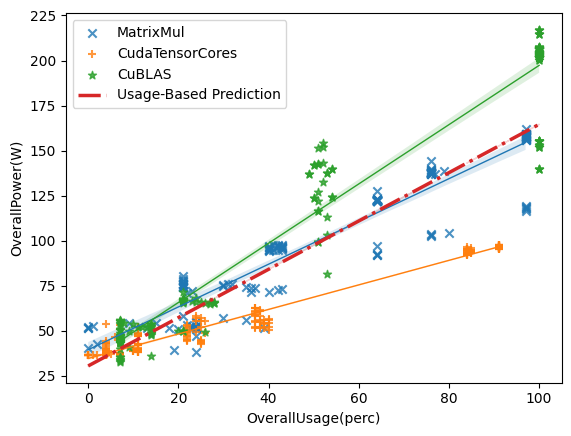

In [105]:
#sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)', label='Overall')
sns.regplot(df[df['benchmark'] == 'matrix-mul'], x='OverallUsage(perc)', y='OverallPower(W)', label='MatrixMul',marker="x", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cuda-tensor'], x='OverallUsage(perc)', y='OverallPower(W)', label='CudaTensorCores',marker="+", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cublas'], x='OverallUsage(perc)', y='OverallPower(W)', label='CuBLAS', marker="*", line_kws=dict(linewidth=1))
sns.lineplot(df, x='OverallUsage(perc)', y='prediction', label='Usage-Based Prediction', linewidth=2.5, linestyle='-.')
plt.legend()

# Analyse Histograms

In [193]:
dfh.index

Index(['vector_arithmetic', 'vector_memory', 'branching', 'scalar_arithmetic',
       'scalar_logic', 'scalar_memory'],
      dtype='object')

In [187]:
names = ['cublas', 'cudaTensorCoreGemm', 'matrixMul']

(0.0, 0.6)

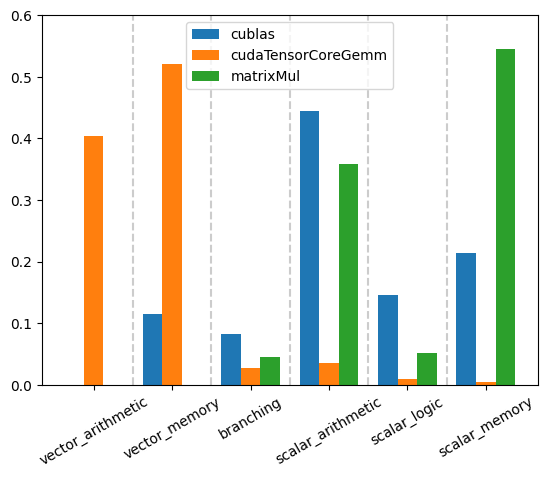

In [216]:
X = np.arange(len(dfh.index))
width = 0.25
multiplier = 0
for name in names:
    offset = width * multiplier
    plt.bar(X + offset, dfh[name], width, label=name)
    multiplier += 1
plt.legend()
_ = plt.xticks(X + width, dfh.index, rotation=30)
plt.vlines(X[:-1] + 0.75, ymin=0, ymax=0.6, color="#CCC", ls="--")
plt.ylim(0, 0.6)